## Import Libraries

In [12]:
## Importing libraries
import pandas as pd
import numpy as np
import cv2
import os
import glob
from PIL import Image
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

from model_ver1 import net_ver1
from model_ver2 import net_ver2
from model_ver3 import net_ver3

from train import train


## Loading Data

In [13]:
DIRECTORY = '../Data/'
CATEGORIES = ['Cloth mask','Mask worn incorrectly','N-95_Mask','No Face Mask','Surgical Mask']

data = []
labels = []
 
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    average1 = 0  
    average2 = 0
    number =  0
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        
        try:
            image = Image.open(img_path)
            average1 +=image.size[0]
            average2 +=image.size[1]
            number +=1
            data.append(image)
            labels.append(category)
        except:
            pass  
    average1 = average1 /number 
    average2 = average2 /number 
    print("Average for class ",category," is ", average1, "X", average2)

Average for class  Cloth mask  is  461.1581508515815 X 422.3211678832117
Average for class  Mask worn incorrectly  is  395.42 X 424.575
Average for class  N-95_Mask  is  327.709219858156 X 289.82978723404256
Average for class  No Face Mask  is  239.9175704989154 X 227.0108459869848
Average for class  Surgical Mask  is  407.1542288557214 X 350.7910447761194


In [25]:
data[1:5]

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=102x102 at 0x20C20B3EA90>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=71x71 at 0x20C1F66B9A0>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=63x63 at 0x20C20B7C0D0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1422x800 at 0x20C1F64B730>]

## Split dataset into train, validation, and test datasets

In [14]:
total_images = len(data)
train_dataset_size = 1580
test_dataset_size = total_images - train_dataset_size
test_dataset_percentage = test_dataset_size/total_images
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=test_dataset_percentage, random_state=42)
data_train, data_val, labels_train, labels_val = train_test_split(data_train, labels_train, test_size=0.1, random_state=42)

In [15]:
print('Before Preprocessing ...')
print('Number of Train Dataset Images:', len(data_train))
print('Number of Validation Dataset Images:', len(data_val))
print('Number of Test Dataset Images:', len(data_test))

Before Preprocessing ...
Number of Train Dataset Images: 1422
Number of Validation Dataset Images: 158
Number of Test Dataset Images: 517


## Preprocessing

In [16]:
# Imagenet standards
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Train uses data augmentation
train_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))  
])
    
# Validation does not use augmentation
test_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])

In [17]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
labels_train = lb_make.fit_transform(labels_train)
labels_val = lb_make.transform(labels_val)
labels_test = lb_make.transform(labels_test)

In [18]:
train_images = []
train_labels = []


for i in range(len(data_train)):
    try:
        train_images.append(train_transforms(data_train[i]))
        train_labels.append(labels_train[i])
    except:
        pass
    
val_images = []
val_labels = []
for i in range(len(data_test)):
    try:
        val_images.append(test_transforms(data_val[i]))
        val_labels.append(labels_val[i])
    except:
        pass

test_images = []
test_labels = []
for i in range(len(data_test)):
    try:
        test_images.append(test_transforms(data_test[i]))
        test_labels.append(labels_test[i])
    except:
        pass

In [19]:
train_images_numpy = [t.numpy() for t in train_images]
val_images_numpy = [t.numpy() for t in val_images]
test_images_numpy = [t.numpy() for t in test_images]

train_images_tensor = torch.tensor(train_images_numpy)
val_images_tensor = torch.tensor(val_images_numpy)
test_images_tensor = torch.tensor(test_images_numpy)

train_labels_tensor = torch.tensor(train_labels)
val_labels_tensor = torch.tensor(val_labels, dtype = torch.long)
test_labels_tensor = torch.tensor(test_labels)

In [20]:
print('After Preprocessing ...')
print('Number of Train Dataset Images:', len(train_images_tensor))
print('Number of Validation Dataset Images:', len(val_images_tensor))
print('Number of Test Dataset Images:', len(test_images_tensor))

After Preprocessing ...
Number of Train Dataset Images: 1359
Number of Validation Dataset Images: 149
Number of Test Dataset Images: 485


## Importing data into Pytroch DataLoader

In [21]:
class CreateDataset:
    def __init__(self, images, labels):
        
        self.images = images
        self.labels = labels
    
    def __getitem__(self, index):
        
        image = self.images[index]
        label = self.labels[index]
        
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [22]:
train_dataset = CreateDataset(images=train_images_tensor, labels=train_labels_tensor)
val_dataset = CreateDataset(images=val_images_tensor, labels=val_labels_tensor)
test_dataset = CreateDataset(images=test_images_tensor, labels=test_labels_tensor)

In [23]:
batch_size_train = 64
batch_size_val = 64
batch_size_test = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size_train,
                                           shuffle=True,
                                           drop_last=False)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=batch_size_val,
                                           shuffle=True,
                                           drop_last=False)                                           

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                         batch_size=batch_size_test,
                                         shuffle=False,
                                         drop_last=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


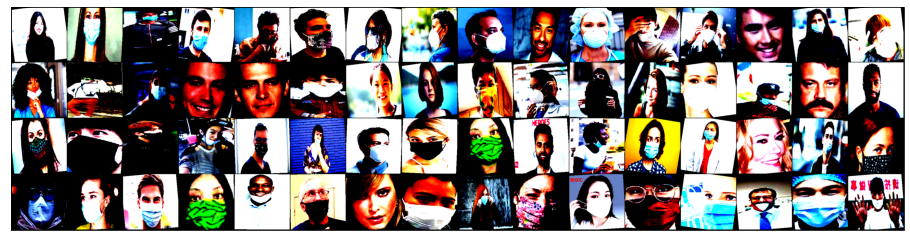

In [24]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)
plt.savefig('Figures/images_after_pre_process.jpg')

## Models

In [19]:
## Model 1

class net_ver1(nn.Module):
    def __init__(self):
        super(net_ver1, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(28 * 28 * 128, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 5)
        )

        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return F.log_softmax(x, dim = 1)


In [20]:
## Model 2

class net_ver2(nn.Module):
    def __init__(self):
        super(net_ver2, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(56 * 56 * 64, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 5)
        )

        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)

        return F.log_softmax(x, dim = 1)

In [27]:
## Model 3

class net_ver3(nn.Module):
    def __init__(self):
        super(net_ver3, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(32)
        )
        
        
        # self.conv2 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        #     nn.LeakyReLU(inplace=True),
        #     nn.BatchNorm2d(64)
        # )
        
        # self.conv3 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        #     nn.LeakyReLU(inplace=True),
        #     nn.BatchNorm2d(128)
        # )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(224 * 224 * 32, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 5)
        )

        
        
    def forward(self, x):
        x = self.conv1(x)
        #x = self.conv2(x)
        #x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return F.log_softmax(x, dim = 1)

### Train and Validation Function

In [16]:
def train(model_info, train_loader, val_loader, num_epochs, early_stopping = False):

    last_loss = 2
    patience = 3
    triggertimes = 0

    model = model_info['model']
    optimizer =  model_info['optimizer']
    criterion = model_info['criterion']
    path = model_info['path']

    loss_train = []
    loss_val = []
    loss_train_avg = []
    loss_val_avg = []

    acc_train = []
    acc_val = []
    acc_train_avg = []
    acc_val_avg = []

    info_loss_acc = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

    # Training
    for epoch in range(num_epochs):
        
        model.train()
        loss_train = []
        acc_train = []
        
        for i, (images,labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_train.append(loss.item())
            
            # Backprop and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Train accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_train.append(correct / total)

        loss_train_avg.append(sum(loss_train)/len(train_loader))
        acc_train_avg.append(sum(acc_train)/len(train_loader))
        
        # Validaiton
        loss_val = []
        acc_val = []
        model.eval()

        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images,labels) in enumerate(val_loader):
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss_val.append(loss.item())
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                acc_val.append(correct / total)

            loss_val_avg.append(sum(loss_val)/len(val_loader))
            acc_val_avg.append(sum(acc_val)/len(val_loader))


        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'
        .format(epoch + 1, num_epochs, loss_train_avg[epoch], acc_train_avg[epoch] * 100,
        loss_val_avg[epoch], acc_val_avg[epoch] * 100))

        if epoch % 1 == 0:
            torch.save(model,path+'model_'+str(epoch)+'.pth')

        if early_stopping:

            if loss_val_avg[epoch] > last_loss:
                trigger_times += 1
                #print('Trigger Times:', trigger_times)

                if trigger_times >= patience:
                    print('Early stopping!\nStart to test process.')
                    return model, info_loss_acc

            else:
                #print('trigger times: 0')
                trigger_times = 0

            last_loss = loss_val_avg[epoch]

    info_loss_acc['train_loss'] = loss_train_avg
    info_loss_acc['train_acc '] = acc_train_avg
    info_loss_acc['val_loss'] = loss_val_avg
    info_loss_acc['val_acc'] = acc_val_avg

    return model, info_loss_acc

### Test function

In [17]:
def test(model, test_loader, num_test_images):

    # Test:
    output_true = []
    output_pred = []
    batch_size_test = 64

    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images,labels) in enumerate(test_loader):
            output_true.append(labels)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            output_pred.append(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = (correct / total) * 100

        print('Testing Accuracy of the model on the test images: {} %'
            .format(test_acc))

    y_pred = np.zeros(num_test_images)
    y_true = np.zeros(num_test_images)
    for i in range(len(output_pred)):
        for j in range(output_pred[i].shape[0]):
            y_pred[i*(batch_size_test)+j] = output_pred[i][j]
            y_true[i*(batch_size_test)+j] = output_true[i][j]

    y_pred = y_pred.reshape(-1)
    y_true = y_true.reshape(-1)

    return model, y_pred, y_true

### Model 1

In [21]:
num_epochs = 50
learning_rate = 0.001
model_1 = net_ver1()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=learning_rate)
model_info_1 = {'model':model_1, 'optimizer':optimizer, 'criterion':criterion, 'path':'Models/ver1/'}

In [135]:
model_1, info_loss_acc_1 = train(model_info_1, train_loader, val_loader, num_epochs)

Epoch [1/50], Train Loss: 1.4231, Train Accuracy: 41.64, Validation Loss: 1.4135, Validation Accuracy: 45.12%
Epoch [2/50], Train Loss: 1.2890, Train Accuracy: 51.20, Validation Loss: 1.2065, Validation Accuracy: 49.59%
Epoch [3/50], Train Loss: 1.1992, Train Accuracy: 53.86, Validation Loss: 1.1733, Validation Accuracy: 52.16%
Epoch [4/50], Train Loss: 1.1195, Train Accuracy: 58.27, Validation Loss: 1.1359, Validation Accuracy: 56.26%
Epoch [5/50], Train Loss: 1.0528, Train Accuracy: 61.79, Validation Loss: 1.1252, Validation Accuracy: 57.00%
Epoch [6/50], Train Loss: 0.9959, Train Accuracy: 64.52, Validation Loss: 1.0558, Validation Accuracy: 56.37%
Epoch [7/50], Train Loss: 0.9320, Train Accuracy: 66.90, Validation Loss: 1.0244, Validation Accuracy: 58.19%
Epoch [8/50], Train Loss: 0.8785, Train Accuracy: 69.91, Validation Loss: 0.9928, Validation Accuracy: 60.72%
Epoch [9/50], Train Loss: 0.8585, Train Accuracy: 69.82, Validation Loss: 0.9741, Validation Accuracy: 62.40%
Epoch [10/

In [149]:
load_model = True
path = 'Models/ver1/model_30.pth'
if load_model == True:
    model_1 = torch.load(path)
    model_1.eval()
num_test_images = len(test_images_tensor)
model_1, y_pred_1, y_true_1 = test(model_1, test_loader, num_test_images)

Testing Accuracy of the model on the test images: 68.8659793814433 %


In [143]:
loss_train_avg = info_loss_acc_1['train_loss']
acc_train_avg = info_loss_acc_1['train_acc ']
loss_val_avg = info_loss_acc_1['val_loss'] 
acc_val_avg = info_loss_acc_1['val_acc'] 

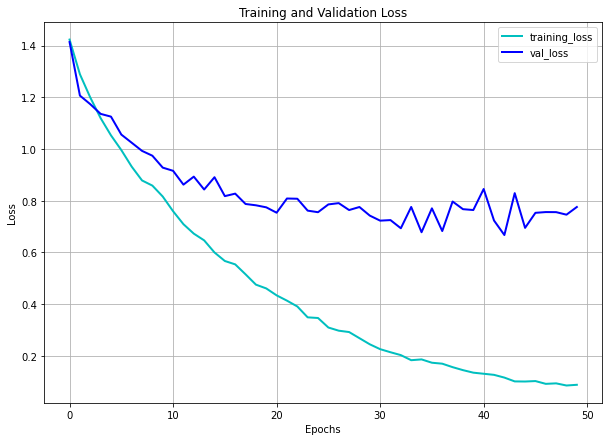

In [157]:
## Loss
plt.figure(figsize=(10,7))
plt.plot(loss_train_avg, 'c', markersize=12, markeredgewidth=3
         , linewidth=2,label='training_loss')
plt.plot(loss_val_avg, 'b', markersize=12, markeredgewidth=3
         , linewidth=2,label='val_loss')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.savefig('Figures/ver1/loss.jpg')

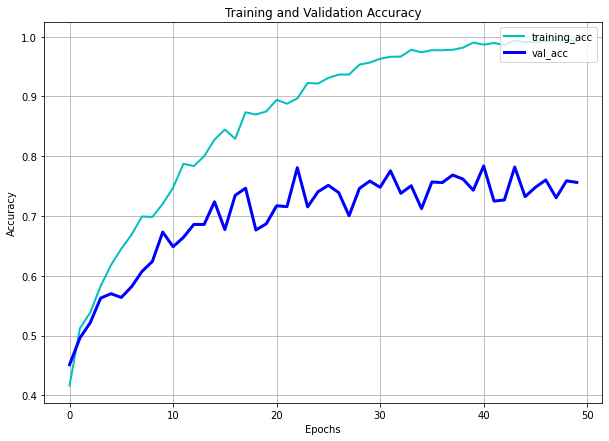

In [159]:
## Accuracy
plt.figure(figsize=(10,7))
plt.plot(acc_train_avg, 'c', markersize=12, markeredgewidth=3
         , linewidth=2,label='training_acc')
plt.plot(acc_val_avg, 'b', markersize=8, markeredgewidth=3
         , linewidth=3,label='val_acc')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.savefig('Figures/ver1/accuracy.jpg')

In [146]:
print('Classification Report: \n', classification_report(y_true_1, y_pred_1))
conf_mat = confusion_matrix(y_true_1, y_pred_1)
print('confusiton matrix: \n', conf_mat)

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.61      0.72      0.66        82
         1.0       0.63      0.36      0.46       105
         2.0       0.63      0.86      0.73        92
         3.0       0.85      0.78      0.82       119
         4.0       0.65      0.71      0.68        87

    accuracy                           0.68       485
   macro avg       0.68      0.69      0.67       485
weighted avg       0.69      0.68      0.67       485

confusiton matrix: 
 [[59  6  5  5  7]
 [23 38 18  7 19]
 [ 5  0 79  3  5]
 [ 2 15  7 93  2]
 [ 7  1 16  1 62]]


## Model 2

In [22]:
num_epochs = 50
learning_rate = 0.001
model_2 = net_ver2()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=learning_rate)
model_info_2 = {'model':model_2, 'optimizer':optimizer, 'criterion':criterion, 'path':'Models/ver2/'}

In [161]:
model_2, info_loss_acc_2 = train(model_info_2, train_loader, val_loader, num_epochs)

Epoch [1/50], Train Loss: 1.5054, Train Accuracy: 33.98, Validation Loss: 1.5098, Validation Accuracy: 44.30%
Epoch [2/50], Train Loss: 1.3206, Train Accuracy: 45.71, Validation Loss: 1.2806, Validation Accuracy: 47.95%
Epoch [3/50], Train Loss: 1.1873, Train Accuracy: 52.79, Validation Loss: 1.1803, Validation Accuracy: 57.11%
Epoch [4/50], Train Loss: 1.0869, Train Accuracy: 59.28, Validation Loss: 1.0931, Validation Accuracy: 55.32%
Epoch [5/50], Train Loss: 0.9708, Train Accuracy: 67.06, Validation Loss: 1.0222, Validation Accuracy: 56.44%
Epoch [6/50], Train Loss: 0.8995, Train Accuracy: 68.73, Validation Loss: 0.9765, Validation Accuracy: 58.79%
Epoch [7/50], Train Loss: 0.8278, Train Accuracy: 72.51, Validation Loss: 0.9623, Validation Accuracy: 68.39%
Epoch [8/50], Train Loss: 0.7765, Train Accuracy: 73.93, Validation Loss: 0.9126, Validation Accuracy: 68.91%
Epoch [9/50], Train Loss: 0.7386, Train Accuracy: 76.64, Validation Loss: 0.9427, Validation Accuracy: 72.19%
Epoch [10/

In [ ]:
path = 'Models/ver3/model_30.pth'
load_model = False
if load_model == True:
    model_3 = torch.load(path)
    model_3.eval()
num_test_images = len(test_images_tensor)
model_3, y_pred_3, y_true_3 = test(model_3, test_loader, num_test_images)

In [ ]:
loss_train_avg = info_loss_acc_3['train_loss']
acc_train_avg = info_loss_acc_3['train_acc ']
loss_val_avg = info_loss_acc_3['val_loss'] 
acc_val_avg = info_loss_acc_3['val_acc'] 

In [ ]:
## Loss
plt.figure(figsize=(10,7))
plt.plot(loss_train_avg, 'c', markersize=12, markeredgewidth=3
         , linewidth=2,label='training_loss')
plt.plot(loss_val_avg, 'b', markersize=12, markeredgewidth=3
         , linewidth=2,label='val_loss')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.savefig('Figures/ver3/loss.jpg')

In [ ]:
## Accuracy
plt.figure(figsize=(10,7))
plt.plot(acc_train_avg, 'c', markersize=12, markeredgewidth=3
         , linewidth=2,label='training_acc')
plt.plot(acc_val_avg, 'b', markersize=8, markeredgewidth=3
         , linewidth=3,label='val_acc')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.savefig('Figures/ver3/accuracy.jpg')

In [168]:
print('Classification Report: \n', classification_report(y_true_2, y_pred_2))
conf_mat = confusion_matrix(y_true_2, y_pred_2)
print('confusiton matrix: \n', conf_mat)

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.53      0.76      0.63        82
         1.0       0.64      0.42      0.51       105
         2.0       0.67      0.78      0.72        92
         3.0       0.86      0.78      0.82       119
         4.0       0.67      0.64      0.65        87

    accuracy                           0.67       485
   macro avg       0.67      0.68      0.67       485
weighted avg       0.69      0.67      0.67       485

confusiton matrix: 
 [[62  6  5  3  6]
 [29 44 11  7 14]
 [ 6  3 72  4  7]
 [ 6 13  6 93  1]
 [13  3 14  1 56]]


## Model 3

In [28]:
num_epochs = 50
learning_rate = 0.001
model_3 = net_ver3()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=learning_rate)
model_info_3 = {'model':model_3, 'optimizer':optimizer, 'criterion':criterion, 'path':'Models/ver3/'}

In [29]:
model_3, info_loss_acc_3 = train(model_info_3, train_loader, val_loader, num_epochs, early_stopping=True)

In [ ]:
path = 'Models/ver3/model_30.pth'
load_model = False
if load_model == True:
    model_3 = torch.load(path)
    model_3.eval()
num_test_images = len(test_images_tensor)
model_3, y_pred_3, y_true_3 = test(model_3, test_loader, num_test_images)

In [ ]:
loss_train_avg = info_loss_acc_3['train_loss']
acc_train_avg = info_loss_acc_3['train_acc ']
loss_val_avg = info_loss_acc_3['val_loss'] 
acc_val_avg = info_loss_acc_3['val_acc'] 

In [ ]:
## Loss
plt.figure(figsize=(10,7))
plt.plot(loss_train_avg, 'c', markersize=12, markeredgewidth=3
         , linewidth=2,label='training_loss')
plt.plot(loss_val_avg, 'b', markersize=12, markeredgewidth=3
         , linewidth=2,label='val_loss')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.savefig('Figures/ver3/loss.jpg')

In [ ]:
## Accuracy
plt.figure(figsize=(10,7))
plt.plot(acc_train_avg, 'c', markersize=12, markeredgewidth=3
         , linewidth=2,label='training_acc')
plt.plot(acc_val_avg, 'b', markersize=8, markeredgewidth=3
         , linewidth=3,label='val_acc')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.savefig('Figures/ver3/accuracy.jpg')

In [ ]:
print('Classification Report: \n', classification_report(y_true_3, y_pred_3))
conf_mat = confusion_matrix(y_true_3, y_pred_3)
print('confusiton matrix: \n', conf_mat)